# Previous experience
I am a co-author on the paper <b>Dank or not? Analyzing and predicting the popularity of memes on Reddit</b> which was published in <b>Applied Network Science</b>.  One of my peers performed semantic analysis on the text of our meme dataset to observe the attitude of the memes.  My work on the project pertained to using a gradient boosting model to predict the popularity of a meme based on its features.

Resource used for this notebook: https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

In [60]:
import os.path
import re
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
import pandas as pd
import langdetect as ld

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tiern\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Functions from "Latent Semantic Analysis using Python" on Datacamp

Author : Avinash Navlani

In [61]:
def preprocess_data(doc_set):
    """
    Input  : document list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts

In [62]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our corpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

In [63]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

In [64]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [65]:
def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

<b>End of functions from Datacamp artcile</b>

In [66]:
def removeFromText(pattern, series, space=""):
    return series.apply(lambda s: re.sub(pattern, space, str(s) ))

In [67]:
def cleanText(df):
    patternLinks = "http.*"
    patternAts = "@.*"
    patternNewLine = "\n"
    patternAmp = "amp"
    df['text'] = removeFromText(patternLinks, df['text'])
    df['text'] = removeFromText(patternAts, df['text'])
    df['text'] = removeFromText(patternNewLine, df['text'], " ")
    df['text'] = removeFromText(patternAmp, df['text'], " ")

In [68]:
def getLangs(df):
    langs = []
    for text in df['text']:
        l = ""
        try:
            l = ld.detect(text)
        except:
            l = "error"
        langs.append(l)
    df['langs'] = langs

In [69]:
def removeCovid(df):
    patternCorona1 = "coronavirus"
    patternCovid1 = "covid-19"
    patternCorona2 = "coronaviru"
    patternCovid2 = "covid"
    pattern19 = "19"
    df['text'] = removeFromText(patternCorona1, df['text'])
    df['text'] = removeFromText(patternCovid1, df['text'])
    df['text'] = removeFromText(patternCorona2, df['text'])
    df['text'] = removeFromText(patternCovid2, df['text'])
    df['text'] = removeFromText(pattern19, df['text'])

# Clean the Tweets

In [70]:
df1 = pd.read_csv("first_pull.csv")
df2 = pd.read_csv("second_pull.csv")
df3 = pd.read_csv("thirdpull_earlyLockdown.csv")
df4 = pd.read_csv("fourthpull_midLockdown.csv")
df5 = pd.read_csv("May_data.csv")
df6 = pd.read_csv("June_data.csv")

In [71]:
each = (df1, df2, df3, df4, df5, df6)
DF = pd.concat(each, ignore_index=True)

In [72]:
getLangs(DF)
DF = DF[DF['langs'] == 'en']

In [73]:
cleanText(DF)

# With Gensim
As per the documentation, Gensim lsimodel implements trunctated SVD.  

In [74]:
def model(tweets, words=8, number_of_topics=3):
    model=create_gensim_lsa_model(tweets,number_of_topics,words)

# Topic Coherence
Topic coherence provides a quantity that tells us the extent that the main words in a given topic are semantically related. Essentially, we are taking an average of the pairwise similarity scores of the top words within a topic.  Usually this pertains to the co-occurrences of these words within statements.  The function creates models for different number of topics.  We then use Gensim's Cohernce Model which calculates the coherence score of each model. 


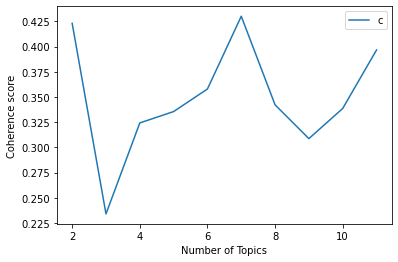

In [75]:
all_tweets = preprocess_data(DF['text'])
start,stop,step=2,12,1
plot_graph(all_tweets,start,stop,step)

In [80]:
model(all_tweets, 8, 7)

[(0, '0.835*"covid" + 0.244*"case" + 0.156*"test" + 0.143*"trump" + 0.142*"new" + 0.096*"death" + 0.093*"coronaviru" + 0.084*"us"'), (1, '0.639*"case" + -0.431*"covid" + 0.305*"new" + 0.292*"coronaviru" + 0.166*"report" + 0.145*"1" + 0.134*"death" + 0.131*"day"'), (2, '-0.753*"trump" + 0.259*"case" + -0.228*"test" + -0.206*"presid" + 0.205*"covid" + -0.122*"peopl" + -0.116*"say" + -0.103*"donald"'), (3, '0.542*"test" + -0.510*"coronaviru" + 0.279*"posit" + 0.221*"case" + -0.203*"us" + -0.161*"death" + -0.159*"die" + 0.148*"new"'), (4, '-0.562*"test" + 0.413*"trump" + -0.368*"coronaviru" + -0.315*"posit" + 0.186*"case" + -0.150*"peopl" + -0.138*"corona" + -0.106*"go"'), (5, '0.433*"corona" + 0.355*"go" + 0.320*"viru" + -0.302*"coronaviru" + 0.239*"shit" + 0.218*"children" + 0.215*"staff" + 0.211*"expos"'), (6, '0.484*"coronaviru" + -0.378*"peopl" + -0.353*"die" + -0.341*"000" + -0.258*"american" + -0.162*"death" + -0.120*"million" + -0.112*"state"')]


# Topics

Topic 1 : (covid, case, test, trump, new, death, coronaviru(s), us)
<br>
Topic 2 : (case, covid, new, coronavirus, report, 1, death, day)
<br>
Topic 3 : (trump, case, test, presid(dent), covid, peopl(e), say, donald)
<br>
Topic 4 : (test, coronaviru(s), posit(ive), case, us, death, die, new)
<br>
Topic 5 : (test, trump, coronaviru(s), posit(ive), case, peopl(e), corona, go)
<br>
Topic 6 : (corona, go, viru(s), coronaviru(s), shit, children, staff, expos(ed))
<br>
Topic 7 : (coronaviru(s), peopl(e), die, 000, american, death, million, state)

In [77]:
removeCovid(DF)

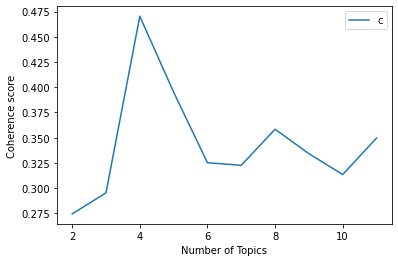

In [78]:
all_tweets = preprocess_data(DF['text'])
start,stop,step=2,12,1
plot_graph(all_tweets,start,stop,step)

In [81]:
model(all_tweets, 8, 4)

[(0, '0.835*"covid" + 0.244*"case" + 0.156*"test" + 0.143*"trump" + 0.142*"new" + 0.096*"death" + 0.093*"coronaviru" + 0.084*"us"'), (1, '-0.639*"case" + 0.431*"covid" + -0.305*"new" + -0.292*"coronaviru" + -0.166*"report" + -0.145*"1" + -0.134*"death" + -0.131*"day"'), (2, '-0.753*"trump" + 0.259*"case" + -0.229*"test" + -0.206*"presid" + 0.205*"covid" + -0.122*"peopl" + -0.116*"say" + -0.103*"donald"'), (3, '-0.542*"test" + 0.510*"coronaviru" + -0.278*"posit" + -0.220*"case" + 0.203*"us" + 0.161*"death" + 0.160*"die" + -0.149*"new"')]


# Our Topics...
Topic 1: (covid, case, test, trump, new, death, coronaviru(s), us)
<br>
Topic 2: (case, covid, new, coronaviru(s), report, 1, death, day)
<br>
Topic 3: (trump, case, test, presid(ent), covid, peopl(e), say, donald)
<br>
Topic 4 : (test, coronaviru(s), posit(ive), case, us, death, die new)
    

# Alternative with Sklearn

Resource: https://www.datascienceassn.org/sites/default/files/users/user1/lsa_presentation_final.pdf

Author: Will Stanton

In [82]:
import sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from sklearn.cluster import KMeans, MiniBatchKMeans
import numpy

In [83]:
stops = set(stopwords.words('english')+["http"])

We need to create a document term matrix.  A matrix with the tokens as the columns and documents as rows.

In [84]:
vectorizer = CountVectorizer(min_df=1, stop_words=stops)
docTermMatrix = vectorizer.fit_transform(DF['text'])
dtm = pd.DataFrame(docTermMatrix.toarray(), index=DF['text'], columns=vectorizer.get_feature_names())

In [85]:
dtm.head()

,00,000,000marks,033k,070,10,100,1003,100b,100daysofcode,...,zone,إختبار,كورونا,للبشرية,هو,والإنسانية,パンデミックとウォール街の関係ーーspecial,𝗔𝗥𝗘,𝗟𝗜𝗩𝗘,𝗪𝗘
text,,,,,,,,,,,,,,,,,,,,,
#16 is my immune system fending off corona,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Everyone knows that we're facing a real crisis from the . But do you know how we got here and what we ne…,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"""She tested for , and her results were delayed. Five days later, she was dead in her kitchen."" She was 3…",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"The Goddard Report with host #CoronaVirus, #ToxicDrugs, and #FakeNews How to turn a non-pandemic int…",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Robert Reich says airlines ‘shouldn’t see a dime of taxpayer money’ in a bailout,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Where SVD comes in...

Below we are using the truncated SVD using the randomized algorithm implemented by Sklearn.  The randomized algorithm makes use of a Randomized Rangefinder.  A Randomized Rangefinder is a problem with a goal of producing an orthonormal matrix Q for an input matrix B.  Q's range must align with the dominant left singular vectors of B. 

In the randomized algorithm, we compute the matrix Q and form matrix C = Q* B.  Then, we find the truncated SVD of C to receive U_hat, Sigma, and V.  U is calculated as Q* U_hat.  Observe the following pseudocode

function RandomRangefinder(B, l):
 // B of size m by n
<ol>
    <li>Form random matrix Omega of size n by l</li>
    <li>Form Y = B * Omega</li>
    <li>Compute [Q, _] = QR_economy(Y)</li>
</ol>

function RSVD(B, l):
<ol>
   // input: Matrix B, l range of Q 
   <li>Q = RandomRangefinder(B, l)</li>
   <li>C = Q*B</li>
   <li>U_hat, Sigma, V = svd_truncated(C)</li>
   <li>U = Q*U_hat</li>
   //optionally truncate the factorization to rank r less than or equal to l
</ol>

source : https://arxiv.org/pdf/2002.01387v1.pdf

In [88]:
lsa = TruncatedSVD(4, algorithm='randomized')
dtm_lsa = lsa.fit_transform(dtm) # From doc: Fit model to X and perform dimensionality reduction on X.
dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa) #Normalizes samples to unit norm

"Scaling inputs to unit norms is a common operation for text classification or clustering for instance. For instance the dot product of two l2-normalized TF-IDF vectors is the cosine similarity of the vectors and is the base similarity metric for the Vector Space Model commonly used by the Information Retrieval community." - sklearn documenation for Normalizer

In [89]:
resultsDF = pd.DataFrame(lsa.components_,index = ["component_1","component_2", "component_3", "component_4"],columns = vectorizer.get_feature_names())

In [90]:
resultsDF

,00,000,000marks,033k,070,10,100,1003,100b,100daysofcode,...,zone,إختبار,كورونا,للبشرية,هو,والإنسانية,パンデミックとウォール街の関係ーーspecial,𝗔𝗥𝗘,𝗟𝗜𝗩𝗘,𝗪𝗘
component_1,0.000129,0.056039,0.000322,0.001846,0.001475,0.014344,0.006955,0.000062,0.000057,0.001501,...,0.003133,0.000071,0.000143,0.000071,0.000071,0.000071,0.000182,0.001367,0.001367,0.001367
component_2,0.000388,0.125000,0.002109,0.010062,0.007877,0.023887,0.026317,-0.000014,0.000186,-0.000006,...,-0.000097,0.000126,0.000253,0.000126,0.000126,0.000126,0.001177,-0.001212,-0.001212,-0.001212
component_3,-0.000036,-0.001319,-0.001116,-0.002547,-0.001687,-0.003392,0.005771,0.000091,0.000041,-0.000808,...,0.003152,0.000151,0.000301,0.000151,0.000151,0.000151,0.000377,-0.000309,-0.000309,-0.000309
component_4,0.000047,-0.053639,0.001496,-0.011916,-0.008188,-0.008859,-0.000229,-0.000091,-0.000246,0.001034,...,-0.002875,-0.000616,-0.001232,-0.000616,-0.000616,-0.000616,-0.003994,-0.000169,-0.000169,-0.000169


In [51]:
vectorizer = CountVectorizer(min_df=1, stop_words=stops)
exampleTweets = vectorizer.fit_transform(DF['text'][0:100])

In [52]:
from sklearn.utils.extmath import randomized_svd

In [53]:
U, Sigma, Vt = randomized_svd(exampleTweets.toarray(), n_components = 2)

# Matrix U

Depends upon shape of your input data.  For our matrix, U represents topic distribution accross documents.

In [59]:
pd.DataFrame(U, index=DF['text'][0:100], columns=['Topic 1', 'Topic 2'])

,Topic 1,Topic 2
text,,
#16 is my immune system fending off corona,0.009634,0.004187
Everyone knows that we're facing a real crisis from the . But do you know how we got here and what we ne…,0.015617,-0.007770
"""She tested for , and her results were delayed. Five days later, she was dead in her kitchen."" She was 3…",0.015076,-0.006064
"The Goddard Report with host #CoronaVirus, #ToxicDrugs, and #FakeNews How to turn a non-pandemic int…",0.050795,0.082349
Robert Reich says airlines ‘shouldn’t see a dime of taxpayer money’ in a bailout,0.008883,0.000789
...,...,...
"Approval of Trump's response underwater, as he returns to c aign trail: POLL",0.025016,-0.012304
It is unacceptable for travel insurance companies not to cover cancellations caused by restrictions instigated by C…,0.005283,-0.002783
"46% of global Covid- deaths are recorded in 3 countries, which only account for 7.8% of global population. What…",0.189996,0.007060


# Matrix Sigma
Below we have our Sigma, which we know consists the singular value of our term document matrix.  In our application, the singular values represent the topic importances.  The matrix provides an idea of how prevalent each topic is amongst the documents.

"Sigma describes the relative strengths of the features. U describes the relationship between terms (rows) and features (columns). The transpose of V describes the relationship between features and documents (columns)." - https://matpalm.com/lsa_via_svd/eg1.html

In [34]:
pd.DataFrame(Sigma, index=['Topic 1', 'Topic 2'], columns=['Topic Importance'])

,Topic Importance
Topic 1,4.123106
Topic 2,3.528383


# Matrix transpose V
V displays the word assignment to each topic.  The column indicates the term and the rows display the score of how the term fits within the topic.

In [35]:
pd.DataFrame(Vt, columns=vectorizer.get_feature_names())

,16,20,airlines,association,bailout,boat,bowtell,branch,brighten,corona,...,thames,town,toxicdrugs,trump,trust,trying,turn,way,wokha,world
0,5.145644e-17,2.425356e-01,-2.210325e-17,2.425356e-01,-8.795596e-18,-2.415586e-16,2.762576e-17,2.425356e-01,-2.360220e-16,4.087448e-17,...,-2.517757e-16,2.425356e-01,3.643825e-17,-7.429863e-17,2.550709e-17,-2.517757e-16,3.643825e-17,-7.429863e-17,4.850713e-01,2.425356e-01
1,3.528709e-17,-1.537419e-16,-4.609933e-16,-6.735429e-17,-3.529844e-16,-3.339454e-15,2.574120e-01,-2.648074e-17,-3.356691e-15,7.269651e-18,...,-3.362526e-15,-2.645957e-17,1.157041e-01,2.600389e-02,2.574120e-01,-3.362526e-15,1.157041e-01,2.600389e-02,-5.291914e-17,-2.645957e-17


# Limitations
The source data was limited.  I could only scrape a limited number of tweets and the querying wasn't specific enough which resulted in pulling data that was not usable for my task.  Further, the data has a lot of noise that is difficult to circumvent. The documents are not always grammatically correct and some tweets in a non-english language still remained present.

# To Conclude
Singular Value Decomposition is a valuable tool in natural language processing.  It allows us to derive relationships between texts and surmise common themes between documents.  The results of SVD have far reaching impacts beyond determining singular values.